In [1]:
# Changing the working directory
import os
abspath = os.path.abspath("./src")
dname = os.path.dirname(abspath)
os.chdir(dname)

# Dependencies

In [2]:
from manim import *

import numpy as np
import pandas as pd
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import sentencepiece as spm
from sklearn.decomposition import PCA
plt.style.use('dark_background')

Manim Community v0.18.0.post0

In [3]:
from src.processing import src_processing
from src.transformer import Transformer

from utils import to_tokens, animate_emb, show_emb, animate_attn, remove_invisible_chars, NN

# Token Embedding

In [4]:
shakespeare = spm.SentencePieceProcessor(model_file="../trained_models/tokenizer/shakespeare_en.model")
modern = spm.SentencePieceProcessor(model_file="../trained_models/tokenizer/modern_en.model")

model = Transformer(emb=256, heads=8, max_seq_len=256, 
                    src_vocab_len=shakespeare.vocab_size(), trg_vocab_len=modern.vocab_size(),
                    num_layers=2)
model.load_state_dict(torch.load("../trained_models/nn_models/model_emb256_heads8_layers2_ep0.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

In [5]:
src_toy = ["My queen! my mistress!  O lady, weep no more"]

# Encoding src
src_id_toy = shakespeare.EncodeAsIds(list(src_toy))

# Tokenized src
src_toy_tok = to_tokens(src_toy, shakespeare, 256, "src")[:len(src_id_toy[0])]

src_id_toy = [src_processing(id, 256) for id in src_id_toy] 

# Moving everything to torch tensors
src_id_toy = torch.tensor(src_id_toy)

In [6]:
%%manim -qk -v WARNING TokEmb

class TokEmb(Scene):
    def Linear(self):
        # Input Layer
        input_layer = VGroup(Circle(color=BLUE))
        for neuron in range(1, 10) :
            input_layer.add(Circle(color=BLUE).next_to(input_layer[-1], DOWN).shift(0.25*DOWN))
            if neuron == 3 or neuron == 6:
                input_layer.add(Tex(r"\vdots", color=BLUE).scale(3).next_to(input_layer[-1], DOWN).shift(0.25*DOWN))
        input_box = SurroundingRectangle(input_layer, color=WHITE)

        # Output Layer
        output_layer = VGroup(Circle(color=BLUE))
        for neuron in range(1, 7) :
            output_layer.add(Circle(color=BLUE).next_to(output_layer[-1], DOWN).shift(0.25*DOWN))
            if neuron == 2 or neuron == 4:
                output_layer.add(Tex(r"\vdots", color=BLUE).scale(3).next_to(output_layer[-1], DOWN).shift(0.25*DOWN))
        output_box = SurroundingRectangle(output_layer, color=WHITE)
        VGroup(output_layer, output_box).next_to(VGroup(input_layer, input_box), RIGHT).shift(5*RIGHT)

        # Connections
        connections = VGroup()
        for neuron_1 in input_layer:
            if isinstance(neuron_1, Circle):
                for neuron_2 in output_layer:
                    if isinstance(neuron_2, Circle):
                        connection = Line(neuron_1.get_edge_center(RIGHT), neuron_2.get_edge_center(LEFT), color=GREEN).set_stroke(width=2.5)
                        connections.add(connection)

        return VGroup(input_layer, input_box), VGroup(output_layer, output_box), connections

    def construct(self):
        # Introduction
        src = Tex("My queen! my mistress!  O lady, weep no more").shift(3*UP)
        src_id = shakespeare.EncodeAsIds("My queen! my mistress!  O lady, weep no more")
        src_id = Tex(' '.join(map(str, src_id))).scale(1.1).next_to(src, DOWN)
        self.play(Write(src))
        self.wait(1)
        self.play(Write(src_id))
        self.wait(5)
        self.play(FadeOut(src, src_id))
        self.wait(1)

        # PyTorch Embedding
        rendered_code = Code(file_name="../data/tok_emb.py", tab_width=4, background="window",
                            language="Python", font="Monospace", insert_line_no=False,
                            style="dracula", line_spacing=1).scale(0.43).to_edge(RIGHT)
        rendered_code.code = remove_invisible_chars(rendered_code.code)
        self.play(Create(rendered_code[0]), Write(rendered_code.code[0:2]), Write(rendered_code.code[2][:28]))
        self.wait(1)

        input_layer, output_layer, connections = self.Linear()
        VGroup(input_layer, output_layer, connections).scale(0.25).move_to(ORIGIN).to_edge(LEFT).shift(2.8*RIGHT)
        vocab_brace = Brace(input_layer[1], sharpness=1, direction=[-1, 0, 0]).shift(LEFT)
        vocab_text = Tex("Vocab Length").scale(0.5).next_to(vocab_brace, LEFT)
        emb_brace = Brace(output_layer[1], sharpness=1, direction=[1, 0, 0])
        emb_text = Tex("Emb Dim").scale(0.5).next_to(emb_brace, RIGHT)

        tok1 = Tex("queen").scale(0.75).next_to(input_layer[0][1], LEFT)
        tok2 = Tex("my").scale(0.75).next_to(input_layer[0][3], LEFT)
        tok3 = Tex("lady").scale(0.75).next_to(input_layer[0][6], LEFT)
        tok4 = Tex("weep").scale(0.75).next_to(input_layer[0][9], LEFT)
        tok5 = Tex("no").scale(0.75).next_to(input_layer[0][10], LEFT)
        tokens = VGroup(tok1, tok2, tok3, tok4, tok5)
        
        self.play(Create(VGroup(input_layer, output_layer, connections, tokens)))
        self.wait(1)
        self.play(Create(VGroup(vocab_brace, vocab_text, emb_brace, emb_text)), Write(rendered_code.code[2][28:]))
        self.wait(1)
        self.play(Write(rendered_code.code[3:]))
        self.wait(1)

        model.load_state_dict(torch.load("../trained_models/nn_models/model_emb256_heads8_layers2_ep{}.pt".format(454), map_location=torch.device('cpu')))
        src_embs = model.src_token_emb(src_id_toy)[0]

        # Light Up Queen
        tok = Tex("1", color=RED).scale(0.5).move_to(input_layer[0][1])
        self.play(input_layer[0][1].animate.set_fill(color=WHITE, opacity=1), Write(tok))
        self.play(ApplyMethod(connections.set_color, RED), run_time=0.1)
        self.play(ApplyMethod(connections.set_color, GREEN), run_time=0.1)
        embs = []
        embs_ = []
        i = 0
        for neuron in output_layer[0]:
            if isinstance(neuron, Circle):
                embs.append(Tex(str(np.round(src_embs[1][i].item()/src_embs[1].max().item(), 1)), color=BLUE_B).scale(0.45).move_to(neuron))
                embs_.append(neuron.animate.set_fill(color=WHITE, opacity=np.abs(src_embs[1][i].item()/src_embs[1].max().item())))
            i += 1
        self.play(*[Write(_) for _ in embs], *embs_)
        self.wait(1)
        embs_ = []
        i = 0
        for neuron in output_layer[0]:
            if isinstance(neuron, Circle):
                embs_.append(neuron.animate.set_fill(color=WHITE, opacity=0))
            i += 1
        self.play(input_layer[0][1].animate.set_fill(color=WHITE, opacity=0), FadeOut(tok, *embs), *embs_)
        self.wait(1)

        # Light Up my
        tok = Tex("1", color=RED).scale(0.5).move_to(input_layer[0][3])
        self.play(input_layer[0][3].animate.set_fill(color=WHITE, opacity=1), Write(tok))
        self.play(ApplyMethod(connections.set_color, RED), run_time=0.1)
        self.play(ApplyMethod(connections.set_color, GREEN), run_time=0.1)
        embs = []
        embs_ = []
        i = 0
        for neuron in output_layer[0]:
            if isinstance(neuron, Circle):
                embs.append(Tex(str(np.round(src_embs[3][i].item()/src_embs[3].max().item(), 1)), color=BLUE_B).scale(0.45).move_to(neuron))
                embs_.append(neuron.animate.set_fill(color=WHITE, opacity=np.abs(src_embs[3][i].item()/src_embs[3].max().item())))
            i += 1
        self.play(*[Write(_) for _ in embs], *embs_)
        self.wait(1)
        embs_ = []
        i = 0
        for neuron in output_layer[0]:
            if isinstance(neuron, Circle):
                embs_.append(neuron.animate.set_fill(color=WHITE, opacity=0))
            i += 1
        self.play(input_layer[0][3].animate.set_fill(color=WHITE, opacity=0), FadeOut(tok, *embs), *embs_)
        self.wait(1)

        # Light Up lady
        tok = Tex("1", color=RED).scale(0.5).move_to(input_layer[0][6])
        self.play(input_layer[0][6].animate.set_fill(color=WHITE, opacity=1), Write(tok))
        self.play(ApplyMethod(connections.set_color, RED), run_time=0.1)
        self.play(ApplyMethod(connections.set_color, GREEN), run_time=0.1)
        embs = []
        embs_ = []
        i = 0
        for neuron in output_layer[0]:
            if isinstance(neuron, Circle):
                embs.append(Tex(str(np.round(src_embs[6][i].item()/src_embs[6].max().item(), 1)), color=BLUE_B).scale(0.45).move_to(neuron))
                embs_.append(neuron.animate.set_fill(color=WHITE, opacity=np.abs(src_embs[6][i].item()/src_embs[6].max().item())))
            i += 1
        self.play(*[Write(_) for _ in embs], *embs_)
        self.wait(1)
        embs_ = []
        i = 0
        for neuron in output_layer[0]:
            if isinstance(neuron, Circle):
                embs_.append(neuron.animate.set_fill(color=WHITE, opacity=0))
            i += 1
        self.play(input_layer[0][6].animate.set_fill(color=WHITE, opacity=0), FadeOut(tok, *embs), *embs_)
        self.wait(1)

        # Light Up weep
        tok = Tex("1", color=RED).scale(0.5).move_to(input_layer[0][9])
        self.play(input_layer[0][9].animate.set_fill(color=WHITE, opacity=1), Write(tok))
        self.play(ApplyMethod(connections.set_color, RED), run_time=0.1)
        self.play(ApplyMethod(connections.set_color, GREEN), run_time=0.1)
        embs = []
        embs_ = []
        i = 0
        for neuron in output_layer[0]:
            if isinstance(neuron, Circle):
                embs.append(Tex(str(np.round(src_embs[9][i].item()/src_embs[9].max().item(), 1)), color=BLUE_B).scale(0.45).move_to(neuron))
                embs_.append(neuron.animate.set_fill(color=WHITE, opacity=np.abs(src_embs[9][i].item()/src_embs[9].max().item())))
            i += 1
        self.play(*[Write(_) for _ in embs], *embs_)
        self.wait(1)
        embs_ = []
        i = 0
        for neuron in output_layer[0]:
            if isinstance(neuron, Circle):
                embs_.append(neuron.animate.set_fill(color=WHITE, opacity=0))
            i += 1
        self.play(input_layer[0][9].animate.set_fill(color=WHITE, opacity=0), FadeOut(tok, *embs), *embs_)
        self.wait(1)

        # Light Up no
        tok = Tex("1", color=RED).scale(0.5).move_to(input_layer[0][10])
        self.play(input_layer[0][10].animate.set_fill(color=WHITE, opacity=1), Write(tok))
        self.play(ApplyMethod(connections.set_color, RED), run_time=0.1)
        self.play(ApplyMethod(connections.set_color, GREEN), run_time=0.1)
        embs = []
        embs_ = []
        i = 0
        for neuron in output_layer[0]:
            if isinstance(neuron, Circle):
                embs.append(Tex(str(np.round(src_embs[10][i].item()/src_embs[10].max().item(), 1)), color=BLUE_B).scale(0.45).move_to(neuron))
                embs_.append(neuron.animate.set_fill(color=WHITE, opacity=np.abs(src_embs[10][i].item()/src_embs[10].max().item())))
            i += 1
        self.play(*[Write(_) for _ in embs], *embs_)
        self.wait(1)
        embs_ = []
        i = 0
        for neuron in output_layer[0]:
            if isinstance(neuron, Circle):
                embs_.append(neuron.animate.set_fill(color=WHITE, opacity=0))
            i += 1
        self.play(input_layer[0][10].animate.set_fill(color=WHITE, opacity=0), FadeOut(tok, *embs), *embs_)
        self.wait(1)
        
        # Transition
        self.play(FadeOut(rendered_code, vocab_brace, vocab_text, emb_brace, emb_text, tokens))
        self.wait(10)
        
        # Transition
        self.play(
            *[FadeOut(mob)for mob in self.mobjects]
        )
        self.wait(1)

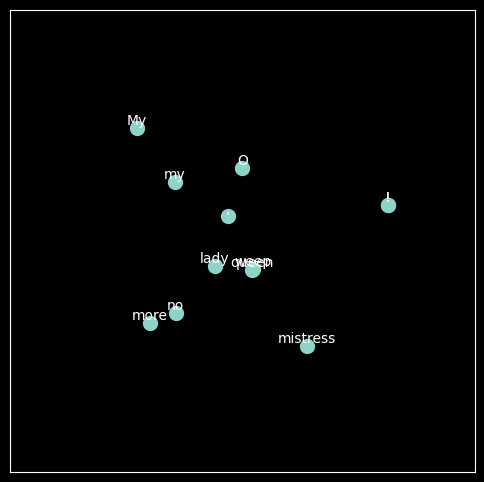

In [24]:
plt.rcParams["figure.figsize"] = (6,6)

# Embeddings over time
src_embs = []

# Embeddings over time
for i in range(0, 150):
    model.load_state_dict(torch.load("../trained_models/nn_models/model_emb256_heads8_layers2_ep{}.pt".format(0), map_location=torch.device('cpu')))

    # Embeddings as the model is trained
    src_embs.append(model.src_token_emb(src_id_toy))

for i in range(0, 455):
    model.load_state_dict(torch.load("../trained_models/nn_models/model_emb256_heads8_layers2_ep{}.pt".format(i), map_location=torch.device('cpu')))

    # Embeddings as the model is trained
    src_embs.append(model.src_token_emb(src_id_toy))

for i in range(0, 150):
    model.load_state_dict(torch.load("../trained_models/nn_models/model_emb256_heads8_layers2_ep{}.pt".format(454), map_location=torch.device('cpu')))

    # Embeddings as the model is trained
    src_embs.append(model.src_token_emb(src_id_toy))

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter plot and text annotations
num_toks = len(src_toy_tok)
data = src_embs[0].detach().numpy()[0][:num_toks]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)
x, y = X_pca[:,0], X_pca[:,1]
scat = ax.scatter(x, y, s=100)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)
texts = [ax.text(x[i], y[i], src_toy_tok[i], ha='center', va='bottom') for i in range(num_toks)]

def update(frame):
    # Update the data points
    data = src_embs[frame].detach().numpy()[0][:num_toks]
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(data)
    x, y = X_pca[:,0], X_pca[:,1]

    # Update the scatter plot
    scat.set_offsets(np.column_stack((x, y)))

    # Update the text annotations
    for i, text in enumerate(texts):
        text.set_position((x[i], y[i]+0.005))

    return scat, *texts

ani = FuncAnimation(fig, update, frames=len(src_embs), interval=1, blit=True)

# Save the animation as an MP4 file
ani.save('./media/videos/animations/TokEmbIntro.mp4', writer='ffmpeg', fps=60, dpi=300)

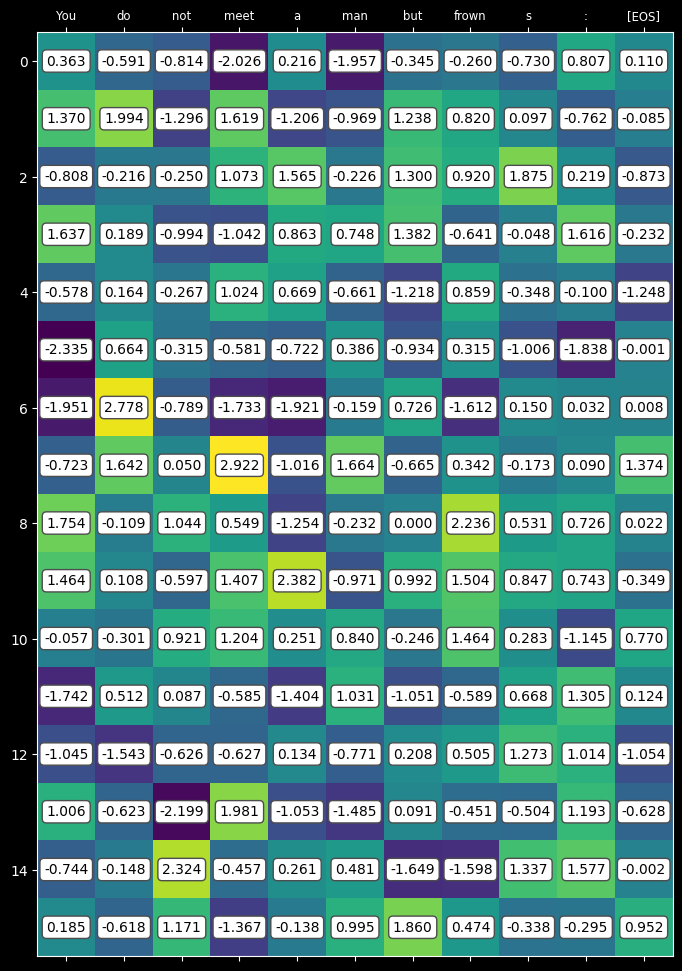

In [79]:
plt.rcParams["figure.figsize"] = (12,12)

# Example Sentence
df = pd.read_csv("../data/shk2mod.csv", index_col=0)
df.drop("id", axis=1, inplace=True)                                  
d = df.to_numpy()
src_toy = d[0:1,0] 

# Encoding src
src_id_toy = shakespeare.EncodeAsIds(list(src_toy))
src_id_toy = [src_processing(id, 256) for id in src_id_toy] 

# Tokenized src
src_toy_tok = to_tokens(src_toy, shakespeare, 256, "src")

# Moving everything to torch tensors
src_id_toy = torch.tensor(src_id_toy)

# Embeddings over time
src_embs = []

for i in range(200):
    model.load_state_dict(torch.load("../trained_models/nn_models/model_emb256_heads8_layers2_ep{}.pt".format(0), map_location=torch.device('cpu')))
    # Embeddings as the model is trained
    src_embs.append(model.src_token_emb(src_id_toy))

# Embeddings over time
for i in range(0, 455):
    model.load_state_dict(torch.load("../trained_models/nn_models/model_emb256_heads8_layers2_ep{}.pt".format(i), map_location=torch.device('cpu')))
    # Embeddings as the model is trained
    src_embs.append(model.src_token_emb(src_id_toy))

for i in range(200):
    model.load_state_dict(torch.load("../trained_models/nn_models/model_emb256_heads8_layers2_ep{}.pt".format(454), map_location=torch.device('cpu')))
    # Embeddings as the model is trained
    src_embs.append(model.src_token_emb(src_id_toy))

# Create the animation
ani = animate_emb(src_embs, src_toy_tok[:11], 11)

# Save the animation
ani.save('./media/videos/animations/TokEmb.mp4', writer='ffmpeg', fps=60, dpi=300)